In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Thư mục không có tiêu đề/fer2013"

/content/drive/MyDrive/Thư mục không có tiêu đề/fer2013





### **Load_data**



In [ ]:
import os, cv2
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.utils import shuffle
from PIL import Image

def load_fer2013(file_path='data/fer2013.csv'):
    """ Load fer2013.csv dataset from csv file """
    df = pd.read_csv(file_path)
    train = df[df['Usage'] == 'Training']
    val = df[df['Usage'] == 'PublicTest']
    test = df[df['Usage'] == 'PrivateTest']
    return train, val, test

def parse_fer2013(data, target_size=(48, 48), target_channel=1):
    """ Parse fer2013 data to images with specified sizes,
        and one-hot vector as labels """
    real_image_size = (48, 48)
    real_image_channel = 1
    images = np.empty(shape=(len(data), *target_size, target_channel))
    labels = np.empty(shape=(len(data), 1))
    for i, idx in enumerate(data.index):
        img = np.fromstring(data.loc[idx, 'pixels'], dtype='uint8', sep=' ')
        img = np.reshape(img, (48, 48))
        if target_size != real_image_size:
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
        img = img[..., np.newaxis]
        if target_channel != real_image_channel:
            img = np.repeat(img, repeats=target_channel, axis=-1)
        label = data.loc[idx, 'emotion']
        images[i] = img
        labels[i] = label
    labels = to_categorical(labels, 7)
    return images, labels

def fer_csv_to_png(file_path='data/fer2013.csv', data_dir='data/fer/'):
    """ Unpack fer2013.csv file and save images to
        specified folders """
    emotions = {0:'angry', 1:'disgust', 2:'fear',
                3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    df = pd.read_csv(file_path)
    for dataset in ("train", 'val', "test"):
        for emotion in emotions:
            os.mkdir(data_dir + f'{dataset}/{emotion} {emotions[emotion]}')
    count = 0
    for emotion, pixels, usage in zip(df['emotion'],df['pixels'],df['Usage']):
        img = np.fromstring(pixels, dtype='uint8', sep=' ').reshape(48, 48)
        img = Image.fromarray(img)
        count_string = str(count).zfill(6)
        path = data_dir
        if usage == 'Training':
            path += 'train/'
        elif usage == 'PublicTest':
            path += 'val/'
        else:
            path += 'test/'
        emo_label = emotions[emotion]
        img.save(path + f'{emotion} {emo_label}/{emo_label}-{count_string}.png')
        count += 1

### **Plots**

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def plot_face_with_label(face, label, possible_emotions=None):
    fig, ax = plt.subplots()
    ax.imshow(face)
    if possible_emotions and not isinstance(label, str):
        label_idx = np.argmax(label)
        label = possible_emotions[label_idx]
    ax.set_title(label)

def plot_model_history(history):
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(train_acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax2.plot(train_loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax1.set_title("Model accuracy")
    ax2.set_title("Model loss")
    ax1.legend()
    ax2.legend()

def plot_generated_images(data_gen, n_epochs=3, b_size=6, figsize=(11,6)):
    emotions = {0:'angry', 1:'disgust', 2:'fear',
                3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    counter = 0  
    fig, axs = plt.subplots(n_epochs, b_size, figsize=figsize)
    for epoch in range(n_epochs):
        for (x_batch, y_batch) in data_gen:
            for i in range(b_size):
                emotion_label = emotions[np.argmax(y_batch[i])]
                axs[counter][i].imshow(x_batch[i], "gray")
                axs[counter][i].set_title(emotion_label)
                axs[counter][i].set_axis_off()
            break
        data_gen.on_epoch_end()
        counter += 1
    plt.show()
    fig.savefig('assets/gen_faces_.png')

def plot_augumented_images(data_gen, n_epochs=3, b_size=6, figsize=(11,6)):
    counter = 1
    fig = plt.figure(figsize=figsize)
    for epoch in range(n_epochs):
        for i, (x_batch, _) in enumerate(data_gen):
            plt.subplot(b_size, n_epochs, counter)
            plt.imshow(x_batch[0], "gray")
            plt.axis('off')
            counter += 1
            if i == b_size - 1:
                break
    plt.show()
    fig.savefig('assets/aug_faces.png')

### **Generator**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
import numpy as np
import cv2


def init_resnet_generator(data_dir='/content/drive/MyDrive/Thư mục không có tiêu đề/fer2013/data/fer/train', with_aug=True,
                          img_size=(197, 197), batch_size=128):
    """ Initialize resnet generator with specified data flow
        from directory. Minimum ResNet50 img_size - (197, 197) with
        rgb channel """
    if with_aug:
        data_generator = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            rescale=1./255
        )
    else:
        data_generator = ImageDataGenerator(rescale=1./255)
    return data_generator.flow_from_directory(
        data_dir,
        target_size=img_size,
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size)


def init_cnn_generator(with_aug=True):
    """ Initialize simple cnn generator """
    if with_aug:
        data_generator = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=15,
            zoom_range=0.15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            rescale=1./255
        )
    else:
        data_generator = ImageDataGenerator(rescale=1./255)
    return data_generator


class ResizeImageGenerator(Sequence):
    """ Custom image generator which resizes images to
        specified size and generates batches.
        #TODO implement custom augumentation """

    def __init__(self, images, labels, batch_size=64, target_size=(197, 197),
                 n_channels=3, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.images[indexes]
        x_batch = resnet_preprocess(x_batch, target_size=self.target_size,
                                    target_channels=self.n_channels)
        y_batch = self.labels[indexes]
        return x_batch, y_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### ***Build***

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense , Activation , Dropout ,Flatten, SeparableConv2D, Input, BatchNormalization, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras import layers

def build_cnn_model():
    model = Sequential()
    input_shape=(48,48,1)

    # 1. Conv
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    # 2. Conv Layer
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # 3. Conv Layer
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #4. Conv Layer
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(7, activation='softmax'))

    return model

def build_resnet_model():
    """ Initialize model with ResNet50 as base model. Minimum input
        shape of keras_vggface pretrained model is (197, 197, 3).
        For fine tuning batch normalization layers are not frozen. """
    resnet = VGGFace(model='resnet50', include_top=False, input_shape = (197,197,3))
    for layer in resnet.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    model = Sequential([
        resnet,
        Flatten(),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

### **Imports**

In [ ]:
import sys
import os

project_path = os.path.abspath(os.path.join('/'))
if project_path not in sys.path:
    sys.path.append(project_path)

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np

### **Loading datasets**

In [ ]:
train_data, val_data, test_data = load_fer2013(file_path='data/fer2013.csv')
X_train, Y_train = parse_fer2013(train_data)
X_val, Y_val = parse_fer2013(val_data)
X_test, Y_test = parse_fer2013(test_data)

### **Model training parameters**

In [ ]:
batch_size = 128
num_epochs = 50
patience = 20
saved_models_path = 'models/'
dataset_name = 'fer2013'
model_name = '_simple_CNN_1'
history_name = '_hist' + model_name

model_path = saved_models_path + dataset_name + model_name

history_path = saved_models_path + dataset_name + history_name

### **Data generators**

In [ ]:
train_gen = init_cnn_generator(with_aug=True)
val_gen = init_cnn_generator(with_aug=False)

### **Callbacks**

In [ ]:
cpt_path = model_path + '.hdf5'
early_stop = EarlyStopping('val_loss', patience=patience)
model_checkpoint = ModelCheckpoint(cpt_path, save_best_only=True)
callbacks = [model_checkpoint, early_stop]

### **Build and compile model**

In [ ]:
model = build_cnn_model()
opt = Adam(0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### **Training**

In [ ]:
history = model.fit(train_gen.flow(X_train, Y_train),
                    validation_data=val_gen.flow(X_val, Y_val),
                    epochs=num_epochs,
                    steps_per_epoch=len(X_train)//batch_size,
                    validation_steps=len(X_val)//batch_size,
                    callbacks=callbacks)

# Saving final model and history
val_acc = history.history['val_accuracy'][-1]
cnt_epoch = len(history.history['val_accuracy'])
np.save(f'{history_path}-e{cnt_epoch:02d}-a{val_acc:.2f}.npy', history.history)
model.save(f'{model_path}-e{cnt_epoch:02d}-a{val_acc:.2f}.hdf5')

Epoch 1/50
224/224 [==============================] - 5s 23ms/step - loss: 0.8274 - accuracy: 0.6883 - val_loss: 0.9662 - val_accuracy: 0.6406
Epoch 2/50
224/224 [==============================] - 5s 24ms/step - loss: 0.8275 - accuracy: 0.6908 - val_loss: 0.9591 - val_accuracy: 0.6462
Epoch 3/50
224/224 [==============================] - 5s 23ms/step - loss: 0.8428 - accuracy: 0.6889 - val_loss: 0.9555 - val_accuracy: 0.6540
Epoch 4/50
224/224 [==============================] - 5s 23ms/step - loss: 0.8254 - accuracy: 0.6907 - val_loss: 1.0145 - val_accuracy: 0.6161
Epoch 5/50
224/224 [==============================] - 5s 24ms/step - loss: 0.8214 - accuracy: 0.6930 - val_loss: 0.9304 - val_accuracy: 0.6518
Epoch 6/50
224/224 [==============================] - 5s 23ms/step - loss: 0.8291 - accuracy: 0.6894 - val_loss: 0.9853 - val_accuracy: 0.6373
Epoch 7/50
224/224 [==============================] - 5s 23ms/step - loss: 0.8373 - accuracy: 0.6853 - val_loss: 1.1339 - val_accuracy: 0.5938

### **Loading (if needed)**

In [ ]:
history = np.load("models/fer2013_hist_simple_CNN_1-e50-a0.64.npy", allow_pickle=True)
history = history.item()
model = load_model('models/fer2013_simple_CNN_1-e50-a0.64.hdf5')

### **Evaluation**

In [ ]:
X_test = X_test / 255.0
loss, acc = model.evaluate(X_test, Y_test)
print("Model accuracy: {:5.2f}%".format(100 * acc))

113/113 [==============================] - 8s 7ms/step - loss: 0.9183 - accuracy: 0.6684
Model accuracy: 66.84%


### **Ploting curves**

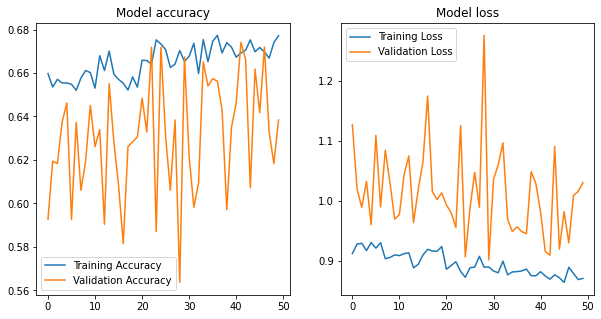

In [ ]:
plot_model_history(history)

In [ ]:
result = tf.keras.models.load_model("models/fer2013_simple_CNN_2-e88-a0.65.hdf5")

In [ ]:
pre = result.predict(X_test[14:15])

1/1 [==============================] - 0s 207ms/step


In [ ]:
ls

assets/  modelsfer2013_hist_resnet50_1-e20-a0.70.npy  model_weights_v1.h5
data/    modelsfer2013_resnet50_1-e20-a0.70.hdf5      notebook/
models/  modelsfer2013_resnet50_1.hdf5                webcam.py


In [ ]:
model1 = load_model("model_weights_v1.h5")

ValueError: ignored